# Regression Week 4: Ridge Regression

In [1]:
import numpy as np
import pandas as pd

In [3]:
dtype_dict = {'bathrooms':float, 'waterfront':int, 'sqft_above':int, 'sqft_living15':float, 'grade':int, 'yr_renovated':int, 'price':float, 'bedrooms':float, 'zipcode':str, 'long':float, 'sqft_lot15':float, 'sqft_living':float, 'floors':float, 'condition':int, 'lat':float, 'date':str, 'sqft_basement':int, 'yr_built':int, 'id':str, 'sqft_lot':int, 'view':int}

sales = pd.read_csv('kc_house_data.csv', dtype=dtype_dict)
sales = sales.sort_values(by=['sqft_living','price'])

In [11]:
def polynomial_sframe(feature, degree):
    poly_sframe = pd.DataFrame()
    poly_sframe['power_1'] = feature
    if degree > 1:
        for power in range(2, degree+1):
            name = 'power_' + str(power)
            poly_sframe[name] = poly_sframe['power_1'].apply(lambda x: x**power)
    return poly_sframe

In [12]:
import matplotlib.pyplot as plt
%matplotlib notebook

In [13]:
l2_small_penalty = 1.5e-5

In [14]:
from sklearn.linear_model import Ridge

In [17]:
poly15_data = polynomial_sframe(sales['sqft_living'], 15)
my_features = poly15_data.columns
poly15_data['price'] = sales['price']
model15 = Ridge(alpha=l2_small_penalty, normalize=True)
model15.fit(poly15_data[my_features], poly15_data['price'].to_numpy().reshape(-1, 1))

Ridge(alpha=1.5e-05, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=True, random_state=None, solver='auto', tol=0.001)

In [18]:
model15.coef_

array([[ 1.24873306e+02, -4.77376011e-02,  3.01446238e-05,
        -2.44419942e-09, -1.94153675e-13,  8.54085686e-18,
         1.51142121e-21,  8.27979094e-26,  6.52603100e-31,
        -3.27895017e-34, -3.87962315e-38, -2.72437650e-42,
        -1.07790800e-46,  3.78242694e-51,  1.39790296e-54]])

# Observe overfitting

In [19]:
set_1 = pd.read_csv('wk3_kc_house_set_1_data.csv',dtype=dtype_dict)
set_2 = pd.read_csv('wk3_kc_house_set_2_data.csv',dtype=dtype_dict)
set_3 = pd.read_csv('wk3_kc_house_set_3_data.csv',dtype=dtype_dict)
set_4 = pd.read_csv('wk3_kc_house_set_4_data.csv',dtype=dtype_dict)

In [20]:
def predict_plot(data,a):
    poly15_data = polynomial_sframe(data['sqft_living'], 15)
    my_features = poly15_data.columns # get the name of the features
    poly15_data['price'] = data['price'] # add price to the data since it's the target
    model_set_1 = Ridge(alpha = a,normalize= True)
    model_set_1.fit(poly15_data[my_features],poly15_data['price'].to_numpy().reshape(-1,1))
    plt.figure()
    plt.plot(poly15_data['power_1'],poly15_data['price'],'.',
    poly15_data['power_1'], model_set_1.predict(poly15_data[my_features]),'-')
    print(my_features.tolist()[0], model_set_1.coef_.tolist()[0][0])

In [21]:
l2_small_penalty = 1e-9

<IPython.core.display.Javascript object>


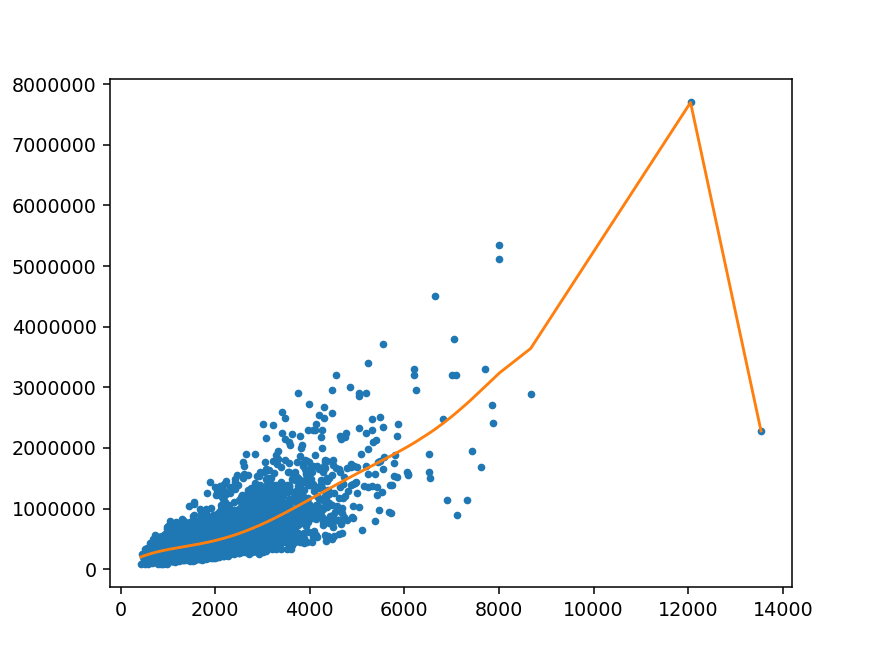

power_1 544.6694334716519


In [22]:
predict_plot(set_1, l2_small_penalty)

<IPython.core.display.Javascript object>


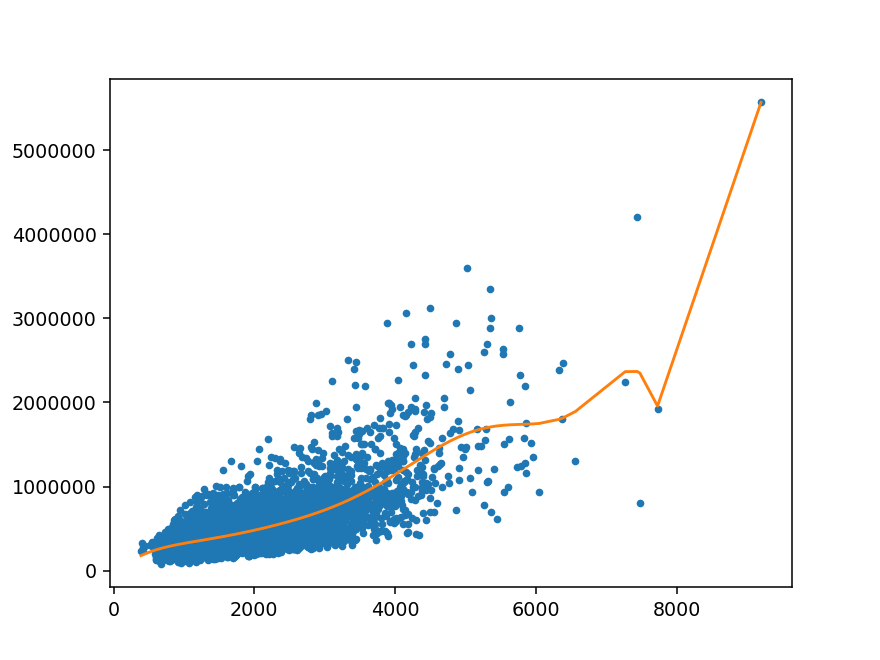

power_1 859.362686754573


In [24]:
predict_plot(set_2, l2_small_penalty)

<IPython.core.display.Javascript object>


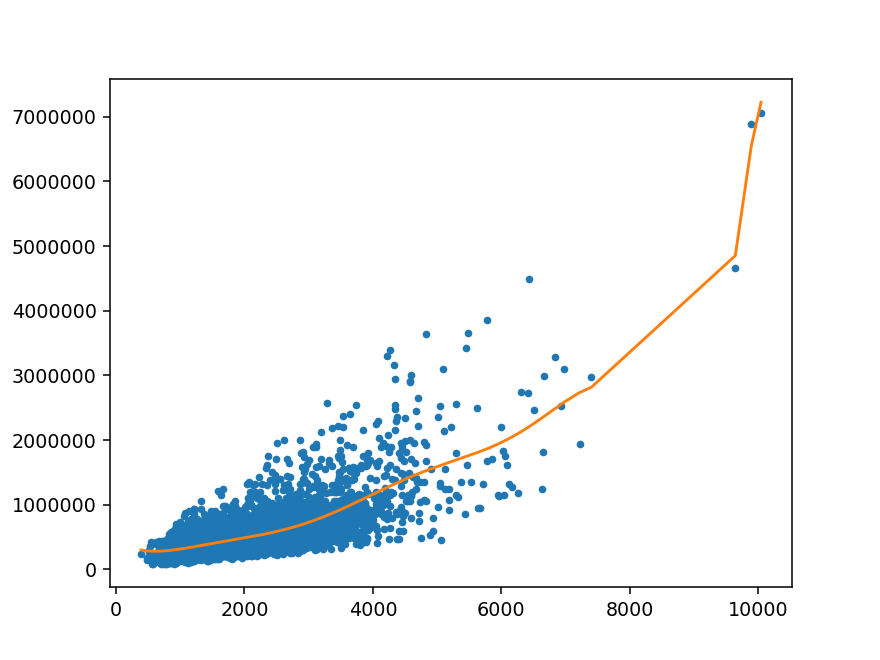

power_1 -755.3958696227204


In [25]:
predict_plot(set_3, l2_small_penalty)

<IPython.core.display.Javascript object>


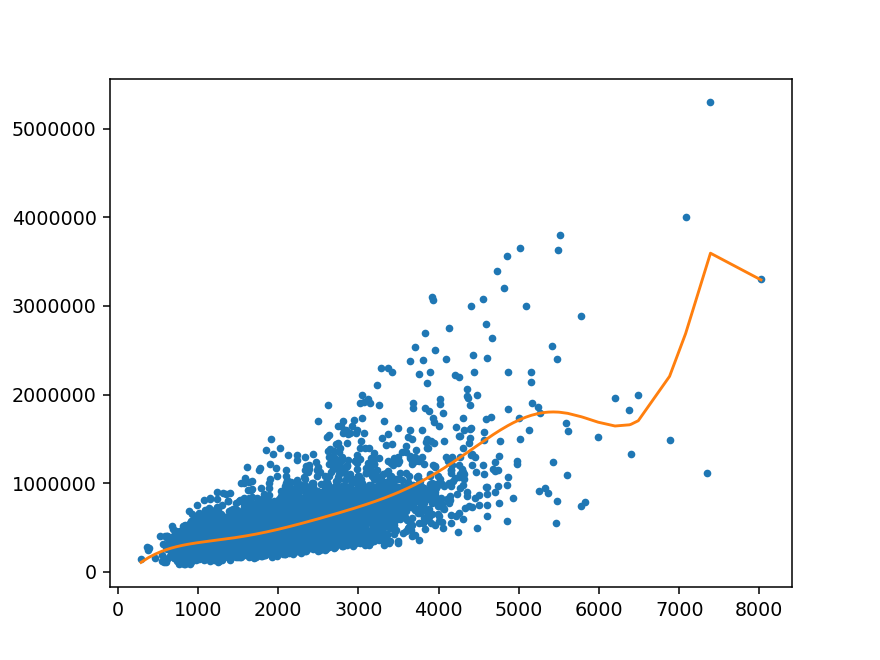

power_1 1119.4456369439113


In [27]:
predict_plot(set_4, l2_small_penalty)

# Ridge regression comes to rescue

In [28]:
l2_large_penalty = 10

<IPython.core.display.Javascript object>


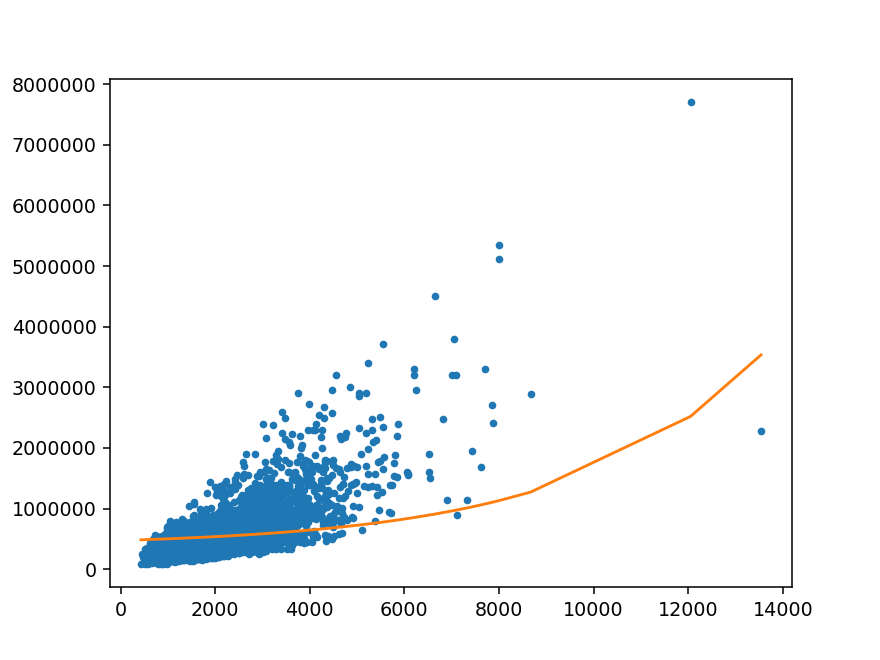

power_1 23.16867165764342


In [29]:
predict_plot(set_1, l2_large_penalty)

<IPython.core.display.Javascript object>


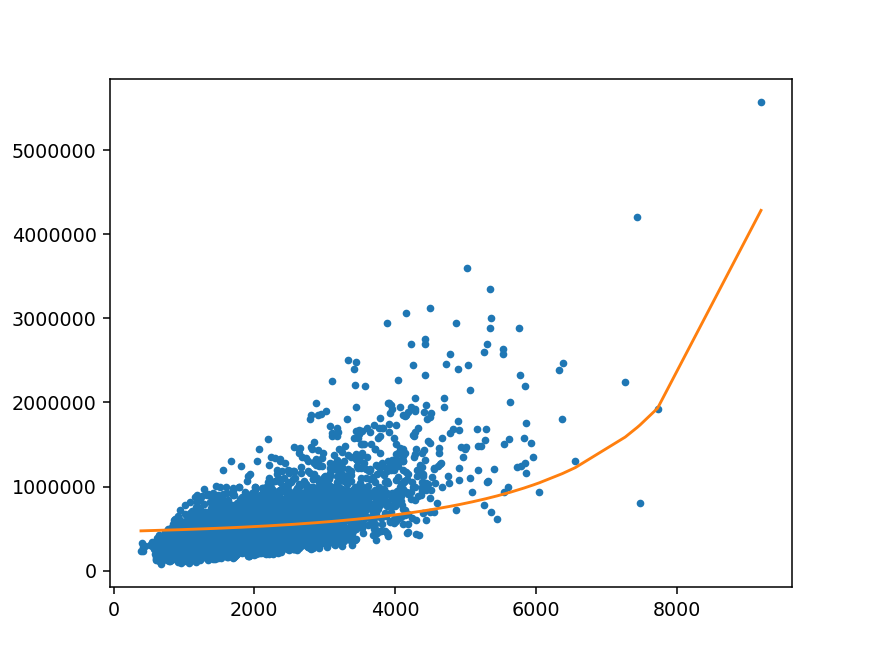

power_1 19.526443042596934


In [31]:
predict_plot(set_2, l2_large_penalty)

<IPython.core.display.Javascript object>


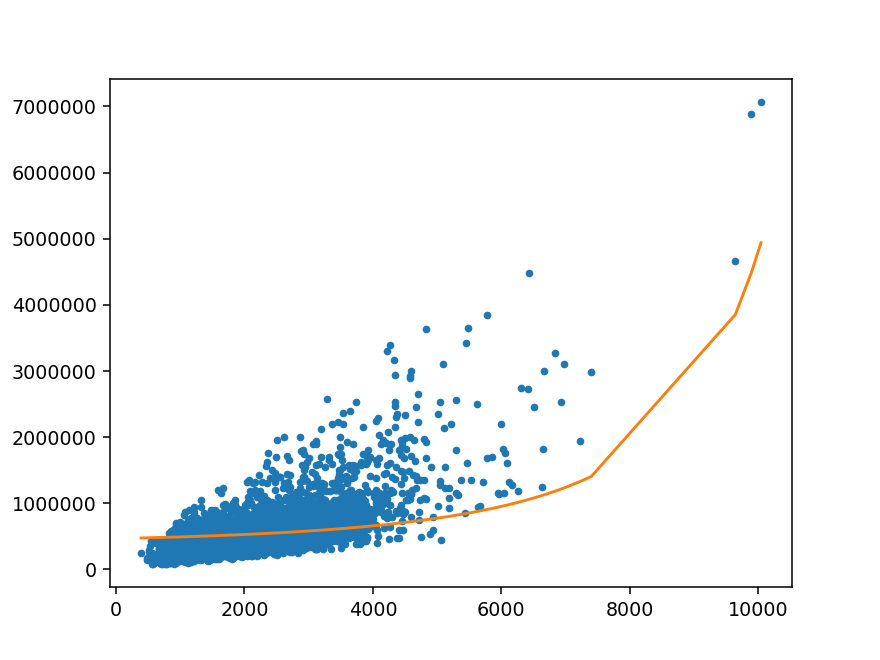

power_1 21.24117076084205


In [32]:
predict_plot(set_3, l2_large_penalty)

<IPython.core.display.Javascript object>


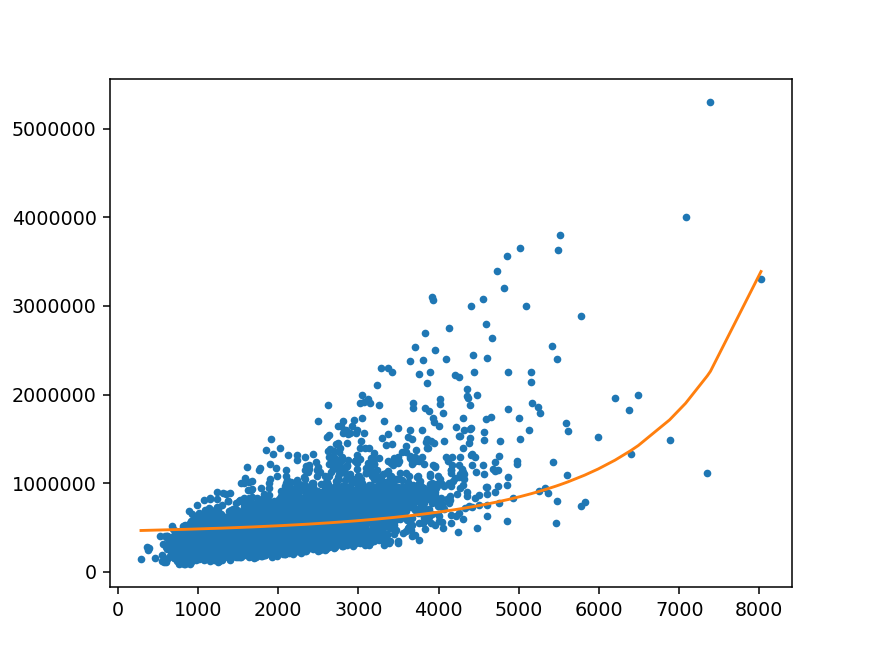

power_1 19.095798464914008


In [33]:
predict_plot(set_4, l2_large_penalty)

# Selecting an L2 penalty via cross-validation

In [34]:
test = pd.read_csv('wk3_kc_house_test_data.csv',dtype=dtype_dict)
train_valid_shuffled = pd.read_csv('wk3_kc_house_train_valid_shuffled.csv',dtype=dtype_dict)

In [38]:
n = len(train_valid_shuffled)
k = 10 # 10-fold cross-validation

for i in range(k):
    start = (n*i)//k
    end = (n*(i+1))//k
    print(i, (start, end))

0 (0, 1939)
1 (1939, 3879)
2 (3879, 5818)
3 (5818, 7758)
4 (7758, 9698)
5 (9698, 11637)
6 (11637, 13577)
7 (13577, 15516)
8 (15516, 17456)
9 (17456, 19396)


In [43]:
def k_fold_cross_validation(k, l2_penalty, data, output_name, features_list):
    avg = 0
    for i in range(k):
        start = (n*i)//k
        end = (n*(i+1))//k
        validation_data = data[start:end+1]
        training_data = data[0:start].append(data[end+1:len(data)])
        model = Ridge(alpha=l2_penalty, normalize=True)
        model.fit(training_data[features_list], training_data[output_name])
        avg = avg + np.square(model.predict(validation_data[features_list])-validation_data[output_name]).sum()
    return avg/k

In [44]:
l2_penalty_values = np.logspace(3, 9, num=13)
poly_shuffled = polynomial_sframe(train_valid_shuffled['sqft_living'],15)
my_features = poly_shuffled.columns
poly_shuffled['price']=train_valid_shuffled['price']
cross_validation_error = list()
for p in l2_penalty_values:
    cvrss = k_fold_cross_validation(10, p, poly_shuffled,'price',my_features )
    print(p,cvrss)
    cross_validation_error.append(cvrss)

1000.0 265017874561645.3
3162.2776601683795 265733493939507.84
10000.0 265964941178385.2
31622.776601683792 266038658206891.6
100000.0 266062022667575.0
316227.7660168379 266069416480160.84
1000000.0 266071755141529.16
3162277.6601683795 266072494744454.84
10000000.0 266072728632762.8
31622776.60168379 266072802595272.5
100000000.0 266072825984325.06
316227766.01683795 266072833380598.16
1000000000.0 266072835719505.66


In [52]:
pd.Series(cross_validation_error, index=l2_penalty_values).sort_values()

1.000000e+03    2.650179e+14
3.162278e+03    2.657335e+14
1.000000e+04    2.659649e+14
3.162278e+04    2.660387e+14
1.000000e+05    2.660620e+14
3.162278e+05    2.660694e+14
1.000000e+06    2.660718e+14
3.162278e+06    2.660725e+14
1.000000e+07    2.660727e+14
3.162278e+07    2.660728e+14
1.000000e+08    2.660728e+14
3.162278e+08    2.660728e+14
1.000000e+09    2.660728e+14
dtype: float64

In [53]:
model_best = Ridge(alpha=l2_penalty_values[0],normalize=True)
model_best.fit(poly_shuffled[my_features],poly_shuffled['price'])

Ridge(alpha=1000.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=True, random_state=None, solver='auto', tol=0.001)

In [54]:
poly_test = polynomial_sframe(test['sqft_living'],15)
poly_test['price']= test['price']
RSS = ((model_best.predict(poly_test[my_features])-poly_test['price'])**2).sum()
RSS

283856861224150.9